In [5]:
import pandas as pd
import json
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data from a file
with open('/Users/bishalthapa/Desktop/2024/Deep Learning/Project/Code/DeepLearningProject/clinc150_uci/data_full.json', 'r') as file:
    data = json.load(file)

In [6]:
# Convert lists to DataFrames
train_df = pd.DataFrame(data['train'], columns=['text', 'intent'])
val_df = pd.DataFrame(data['val'], columns=['text', 'intent'])
test_df = pd.DataFrame(data['test'], columns=['text', 'intent'])
oos_train_df = pd.DataFrame(data['oos_train'], columns=['text', 'intent'])
oos_test_df = pd.DataFrame(data['oos_test'], columns=['text', 'intent'])
oos_val_df = pd.DataFrame(data['oos_val'], columns=['text', 'intent'])

In [7]:
# Prepare the tokenizer for LSTM
lstm_tokenizer = Tokenizer(num_words=10000)
lstm_tokenizer.fit_on_texts(train_df['text'])

# Preprocess the data for LSTM
max_length = 100
train_sequences_padded = pad_sequences(lstm_tokenizer.texts_to_sequences(train_df['text']), maxlen=max_length)
val_sequences_padded = pad_sequences(lstm_tokenizer.texts_to_sequences(val_df['text']), maxlen=max_length)
oos_val_sequences_padded = pad_sequences(lstm_tokenizer.texts_to_sequences(oos_val_df['text']), maxlen=max_length)


In [8]:
# Create a set of all possible labels including in-domain and 'oos'
all_labels = set(train_df['intent']) | {'oos'}

# Create a label index mapping every label to an integer
label_index = {label: idx for idx, label in enumerate(all_labels)}

def encode_labels(labels, label_index):
    return to_categorical([label_index.get(label, label_index['oos']) for label in labels], num_classes=len(label_index))

# Encoding labels for all datasets
train_labels = encode_labels(train_df['intent'], label_index)
val_labels = encode_labels(val_df['intent'], label_index)
oos_val_labels = encode_labels(oos_val_df['intent'], label_index)

In [9]:
# Build and compile the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    LSTM(units=64),
    Dense(len(label_index), activation='softmax')
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
# Train the LSTM model
lstm_model.fit(train_sequences_padded, train_labels, batch_size=128, epochs=10, validation_data=(val_sequences_padded, val_labels))

# Evaluate on combined validation data (in-domain and out-of-domain)
combined_val_sequences_padded = np.concatenate([val_sequences_padded, oos_val_sequences_padded])
combined_val_labels = np.concatenate([val_labels, oos_val_labels])
lstm_model.evaluate(combined_val_sequences_padded, combined_val_labels)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.0317 - loss: 4.9212 - val_accuracy: 0.2420 - val_loss: 4.0062
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.4528 - loss: 3.3124 - val_accuracy: 0.7083 - val_loss: 2.0514
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8401 - loss: 1.4848 - val_accuracy: 0.8140 - val_loss: 1.2007
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9271 - loss: 0.7318 - val_accuracy: 0.8483 - val_loss: 0.8543
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9548 - loss: 0.4222 - val_accuracy: 0.8613 - val_loss: 0.7090
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9701 - loss: 0.2833 - val_accuracy: 0.8700 - val_loss: 0.6285
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9817 - loss: 0.1896 - val_accuracy: 0.8753 - val_loss: 0.5846
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9866 - loss: 0.1463 - val_acc

[0.8627790212631226, 0.85161292552948]

In [11]:
# Prepare test data
test_sequences_padded = pad_sequences(lstm_tokenizer.texts_to_sequences(test_df['text']), maxlen=max_length)
oos_test_sequences_padded = pad_sequences(lstm_tokenizer.texts_to_sequences(oos_test_df['text']), maxlen=max_length)
combined_test_sequences_padded = np.concatenate([test_sequences_padded, oos_test_sequences_padded])

# Predict classes with probabilities
predictions = lstm_model.predict(combined_test_sequences_padded)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
## APPLYTING A THRESHOLD, SO THAT WE CAN LABEL OUT-OF-DOMAIN SAMPLES 
## WE CAN CHOOSE THE THRESHOLD (EXPERTISE REQUIRED)

In [12]:
# Apply threshold to predictions to determine in-domain or out-of-domain
threshold = 0.15
predicted_classes_thresholded = [1 if np.max(pred) < threshold else (1 if np.argmax(pred) == label_index['oos'] else 0) for pred in predictions]


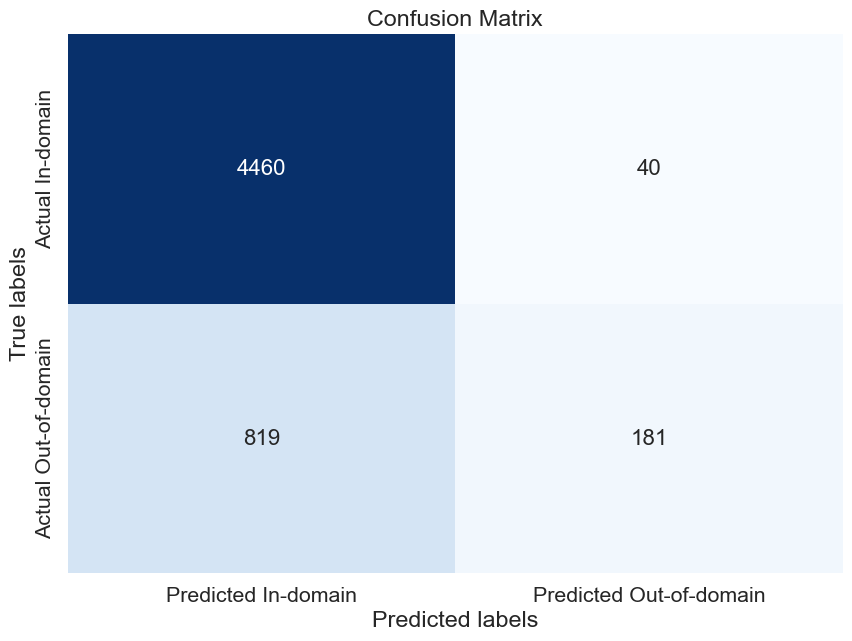

Classification Report:
                precision    recall  f1-score   support

    In-domain       0.84      0.99      0.91      4500
Out-of-domain       0.82      0.18      0.30      1000

     accuracy                           0.84      5500
    macro avg       0.83      0.59      0.60      5500
 weighted avg       0.84      0.84      0.80      5500



In [13]:
# Prepare binary labels for evaluation
binary_test_labels = [1 if label == 'oos' else 0 for label in list(test_df['intent']) + list(oos_test_df['intent'])]

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(binary_test_labels, predicted_classes_thresholded)

# Plotting the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['Predicted In-domain', 'Predicted Out-of-domain'],
            yticklabels=['Actual In-domain', 'Actual Out-of-domain'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
class_report = classification_report(binary_test_labels, predicted_classes_thresholded, target_names=['In-domain', 'Out-of-domain'])
print("Classification Report:\n", class_report)



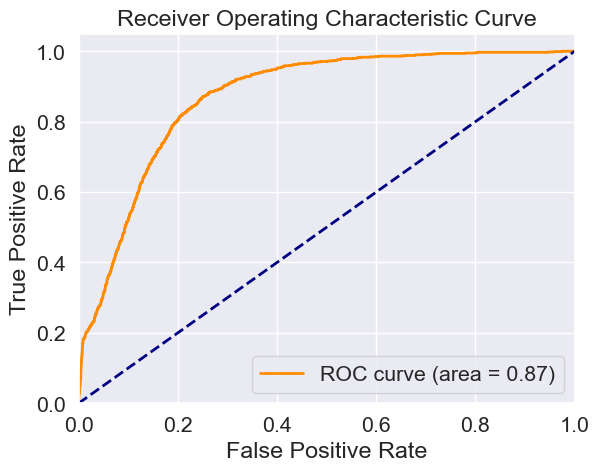

In [14]:
# ROC Curve and AUC: Use predicted probabilities for 'oos' or the lowest class probability as the score
oos_probabilities = [1 - np.max(pred) if np.max(pred) < threshold else pred[label_index['oos']] for pred in predictions]
fpr, tpr, thresholds = roc_curve(binary_test_labels, oos_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()